In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.9 MB 8.2 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
train_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv')
valid_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/valid_combined.csv', index_col=0)

In [ ]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
valid_data

,id,comment_text
0,0,This article sucks \n\nwoo woo wooooooo
1,1,"""And yes, people should recognize that but the..."
2,2,"Western Media?\n\nYup, because every crime in..."
3,3,And you removed it! You numbskull! I don't car...
4,4,smelly vagina \n\nBluerasberry why don't you ...
...,...,...
60211,60211,get out my large penis
60212,60212,get out my large penis
60213,60213,Piss off you slant eyed-gook
60214,60214,Piss off you slant eyed-gook


In [ ]:
import re

In [ ]:
# data cleaning

def text_clean(x):

    x = x.lower()                               # lowercase everything
    x = x.encode('ascii', 'ignore').decode()    # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x)            # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r'=', '', x)
    x = re.sub(r':', '', x)

    return x

In [ ]:
train_data['comment_text'] = train_data['comment_text'].apply(text_clean)
valid_data['comment_text'] = valid_data['comment_text'].apply(text_clean)

In [ ]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d! he matches this background colour i seeming...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i really not trying to edit war. it j...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can make any real suggestions on impr...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,"""and for the second time of asking, when your ...",0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"spitzer umm, theres no actual article for pros...",0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data['comment_text'], train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
len(X_train)

127656

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# The following cell takes 1 hr 21mins to run with GPU

In [ ]:
hist = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/5
3990/3990 [==============================] - 984s 244ms/step - loss: 0.0979 - accuracy: 0.8759 - val_loss: 0.0801 - val_accuracy: 0.9902
Epoch 2/5
3990/3990 [==============================] - 975s 244ms/step - loss: 0.0802 - accuracy: 0.8984 - val_loss: 0.0774 - val_accuracy: 0.9493
Epoch 3/5
3990/3990 [==============================] - 975s 244ms/step - loss: 0.0783 - accuracy: 0.9016 - val_loss: 0.0724 - val_accuracy: 0.9643
Epoch 4/5
3990/3990 [==============================] - 977s 245ms/step - loss: 0.0766 - accuracy: 0.8958 - val_loss: 0.0726 - val_accuracy: 0.9879
Epoch 5/5
3990/3990 [==============================] - 974s 244ms/step - loss: 0.0763 - accuracy: 0.8960 - val_loss: 0.0711 - val_accuracy: 0.9880


In [ ]:
hist.history

{'accuracy': [0.8759165406227112,
  0.8984066843986511,
  0.9015949368476868,
  0.8957667350769043,
  0.8960174322128296],
 'loss': [0.09793206304311752,
  0.08022527396678925,
  0.0782967060804367,
  0.07657977193593979,
  0.07630070298910141],
 'val_accuracy': [0.9902240037918091,
  0.9492715001106262,
  0.9643114805221558,
  0.9878740310668945,
  0.9879680275917053],
 'val_loss': [0.0800538882613182,
  0.07739439606666565,
  0.07239741086959839,
  0.07257986813783646,
  0.07113774120807648]}

In [ ]:
#   Evaluate the model with the test data to get the scores on "real" data.
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))

Test loss: 0.071
Test accuracy: 0.988


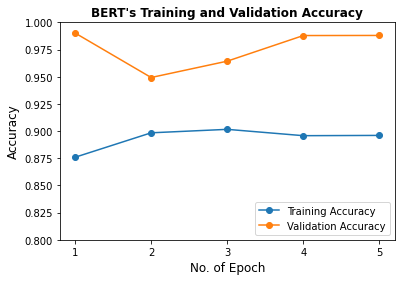

In [ ]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]

plt.xticks(np.arange(1, 6, 1))
plt.ylim([0.8, 1])

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'], marker='o')
plt.title("BERT's Training and Validation Accuracy", fontsize=12, fontweight="bold")
plt.xlabel('No. of Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.savefig('gdrive/MyDrive/Colab Notebooks/jigsaw/BERT_v6.png', bbox_inches='tight')
plt.show()

In [ ]:
pred = model.predict(valid_data["comment_text"])

In [ ]:
pred

array([[2.2373666e-01, 2.5190521e-02, 7.6269343e-02, 2.4636576e-04,
        6.8364069e-02, 1.1190012e-02],
       [3.0913124e-02, 2.2514547e-04, 2.9402003e-03, 5.0442857e-05,
        6.4005880e-03, 1.6281535e-03],
       [6.7170018e-01, 2.4603616e-02, 1.9187406e-01, 7.1354349e-05,
        1.7172992e-01, 6.8376072e-02],
       ...,
       [9.7558731e-01, 4.1992927e-01, 8.8788152e-01, 1.3061185e-02,
        9.0611005e-01, 2.9743403e-01],
       [9.7558731e-01, 4.1992927e-01, 8.8788152e-01, 1.3061185e-02,
        9.0611005e-01, 2.9743403e-01],
       [9.7558731e-01, 4.1992927e-01, 8.8788152e-01, 1.3061185e-02,
        9.0611005e-01, 2.9743403e-01]], dtype=float32)

In [ ]:
result = pd.DataFrame(pred)

In [ ]:
result

,0,1,2,3,4,5
0,0.223737,0.025191,0.076269,0.000246,0.068364,0.011190
1,0.030913,0.000225,0.002940,0.000050,0.006401,0.001628
2,0.671700,0.024604,0.191874,0.000071,0.171730,0.068376
3,0.941778,0.101740,0.600711,0.139955,0.704798,0.043040
4,0.472958,0.022781,0.116613,0.000550,0.152080,0.039376
...,...,...,...,...,...,...
60211,0.704483,0.046468,0.321045,0.002416,0.195133,0.032507
60212,0.704483,0.046468,0.321045,0.002416,0.195133,0.032507
60213,0.975587,0.419929,0.887882,0.013061,0.906110,0.297434
60214,0.975587,0.419929,0.887882,0.013061,0.906110,0.297434


In [ ]:
result.to_csv('gdrive/MyDrive/Colab Notebooks/BERTv6_result.csv')